<center>
<h4>Diplodatos 2020 - FaMAF - UNC</h4>
<h1>Procesamiento de datos georeferenciados</h1>
<h3>Aprendizaje Supervisado</h3>
</center>

### Introducción

En el siguiente trabajo profundizaremos en el proceso de entrenamiento del modelo centrandonos en diferentes formas de seleccion de variables y tuning de hiperparametros.

Para esto construiremos sobre el conocimiento obtenido de los practicos anteriores.

# Aprendizaje Automático Supervisado

## Carga y particion de los datos, en training y test

Antes de comenzar con el analisis debemos partir nuestro dataset en training y test sets.
Carguen el dataset utilizado en el practico anterior, realizen la particion y apliquen un pipeline de preprocesamiento en base a lo realizado en el practico anterior.

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, classification_report
from sklearn.metrics import roc_curve, auc, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

np.random.seed(0)  # Para mayor determinismo

In [92]:
untrd = pd.read_csv('untrd_procesado.csv')
untrd.head()

,TEN_LIN_SE,TAP,POT_NOM,PER_FER,PER_TOT,ENE_01_media,ENE_02_media,ENE_03_media,ENE_04_media,ENE_05_media,...,CNAE_moda_['0' '8630504'],CNAE_moda_['0' '9491000'],CNAE_moda_['9430800' '9491000'],CNAE_moda_nan,TIP_TRAFO_MT,TIP_TRAFO_T,TIP_TRAFO_nan,SIT_ATIV_AT,SIT_ATIV_DS,SIT_ATIV_nan
0,0.23,1.000,15.0,85.0,355.0,58.200000,53.080000,49.720000,55.040000,54.760000,...,0,0,0,0,1,0,0,1,0,0
1,0.23,1.000,10.0,60.0,260.0,68.000000,63.875000,57.625000,65.250000,65.250000,...,0,0,0,0,1,0,0,1,0,0
2,0.23,1.000,10.0,60.0,260.0,65.250000,63.937500,57.187500,63.812500,63.937500,...,0,0,0,0,1,0,0,1,0,0
3,0.22,0.957,15.0,100.0,440.0,51.388889,52.555556,55.722222,55.388889,55.444444,...,0,0,0,0,1,0,0,1,0,0
4,0.23,1.000,10.0,60.0,260.0,40.000000,33.470588,32.941176,35.235294,38.941176,...,0,0,0,0,1,0,0,1,0,0


In [93]:
y = untrd.FIC_media
filter_FIC = [col for col in untrd.columns if col.startswith('FIC')]
untrd.drop(filter_FIC, axis=1, inplace=True)

In [94]:
untrd.shape

(8258, 260)

In [95]:
untrd.columns = untrd.columns.str.replace('[', '')
untrd.columns = untrd.columns.str.replace(']', '')
untrd.columns = untrd.columns.str.replace(' ', '_')

X_train, X_valid, y_train, y_valid = train_test_split(untrd, y, test_size=0.2, random_state=0)

## Baseline

En este practico estaremos utilizando nuevamente un modelo XGBoost, ya que nos permite obtener buenos resultados de manera rapida y ademas cuenta con numerosos hiperparametros que podremos ajustar para optimizar su performance.

Para comenzar definiremos un baseline utilizando los hiperparametros por defecto.

Entrene un modelo XGBoost basico, utilizando los hiperparametros por defecto, seleccione una metrica de error y presente el resultado.

In [96]:
import xgboost as xgb
dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)

In [97]:
xg_reg = xgb.XGBRegressor()
xg_reg.fit(X_train,y_train);
y_train_pred_XGB = xg_reg.predict(X_train)
y_valid_pred_XGB = xg_reg.predict(X_valid)

### Métricas del modelo XGBRegressor con valores por default de los parámetros 

In [98]:
print('Conjunto de entrenamiento: modelo XGBRegressor default')
print('R2: ', r2_score(y_train,y_train_pred_XGB))
print('MAE: ', mean_absolute_error(y_train,y_train_pred_XGB))
print('MSE: ', mean_squared_error(y_train,y_train_pred_XGB, squared=False))

print('Conjunto de validación: modelo XGBRegressor default')
print('R2: ', r2_score(y_valid,y_valid_pred_XGB))
print('MAE: ', mean_absolute_error(y_valid,y_valid_pred_XGB))
print('MSE: ', mean_squared_error(y_valid,y_valid_pred_XGB, squared=False))

Conjunto de entrenamiento: modelo XGBRegressor default
R2:  0.975373979488741
MAE:  0.5311330254702186
MSE:  0.7211807296019828
Conjunto de validación: modelo XGBRegressor default
R2:  0.790544722650728
MAE:  1.535932247716021
MSE:  2.1383686314191794


## Seleccion de variables

La seleccion de variables es un proceso a traves del cual se intentan distinguir las variables que aportan valor de prediccion de las que no, y de esta forma quedarnos solamente con aquellas que impacten positivamente en nuestro algoritmo.

Esto nos traera multiples beneficios, al simplificar el modelo reducimos el riesgo de overfitting, disminuimos el costo computacional de entrenamiento y prediccion y reducimos el ruido introducido por las variables de poco valor.

Existen diversas formas de llevar a cabo este proyecto:
  - Filtros o Reglas: Se especifica alguna metrica o valor estadistico y se eliminan las features que no lo cumplan. Ej: Correlacion maxima entre variables, correlacion minima con la variable de salida, colinealidad entre variables, cantidad de valores nulos.

  - Wrapper Base: Son metodos que se plantean como problemas de busqueda, como por ejemplo la eliminacion recursiva de variables.

  - Metodos embebidos: Algunos metodos de estimacion poseen procesos internos de clasificacion de variables, en donde se le asigna un nivel de importancia a cada una de ellas que puede luego ser utilizado para conocer su importancia. Ejemplos clasicos son los coeficientes de la regresion de Lasso o el feature importance en implementaciones basadas en arboles como XGBoost.

En base al baseline calculado en el punto anterior comience seleccionando las 50 variables mas importantes en base a la informacion provista por XGBoost.

In [99]:
best_features_index = np.absolute(xg_reg.feature_importances_).argsort()[-20:][::1]
best_features = np.absolute(xg_reg.feature_importances_)[best_features_index]
best_features_names = untrd.iloc[:,best_features_index].columns

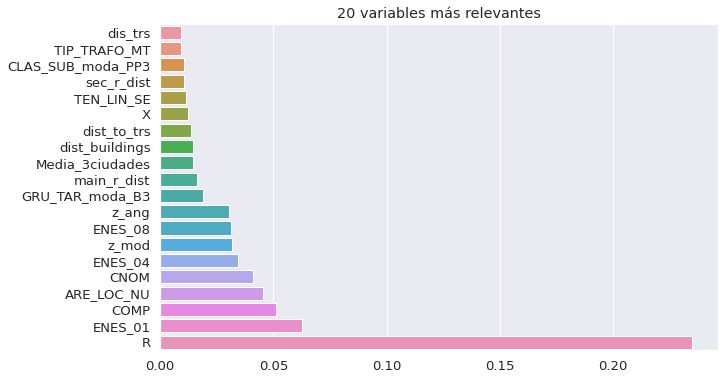

In [100]:
plt.figure(figsize=(10,6))
sns.set(font_scale = 1.2)
sns.barplot(y=best_features_names[-20:], x=best_features[-20:])
plt.title('20 variables más relevantes');

A partir del punto anterior calcule el error para diferentes cantidades de variables, realize un grafico de numero de variables vs error, seleccione el valor de mejor performance y justique.

In [101]:
features = [10, 20, 30, 40, 50, 75, 100, 125, 150]

trainin = []
test = []

for feature in features:
    bfi = np.absolute(xg_reg.feature_importances_).argsort()[-feature:][::1]
    X_train_red =  X_train.iloc[:,bfi]
    X_valid_red =  X_valid.iloc[:,bfi]
    data_dmatrix_red = xgb.DMatrix(data=X_train_red,label=y)
    xgb_red = xgb.XGBRegressor()
    xgb_red.fit(X_train_red,y_train);
    y_train_pred_XGB_red = xgb_red.predict(X_train_red)
    y_valid_pred_XGB_red = xgb_red.predict(X_valid_red)
    test.append(mean_absolute_error(y_valid,y_valid_pred_XGB_red))
    trainin.append(mean_absolute_error(y_train,y_train_pred_XGB_red))

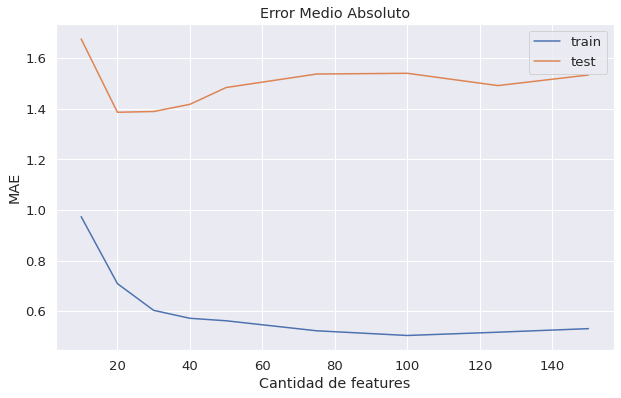

In [102]:
resultados = pd.DataFrame({'features':features, 'R2_trainin':trainin, 'R2_test':test})

plt.figure(figsize=(10,6))
sns.set(font_scale = 1.2)

sns.lineplot(data=resultados, x='features', y='R2_trainin', label='train')
sns.lineplot(data=resultados, x='features', y='R2_test', label='test')
plt.title('Error Medio Absoluto')
plt.xlabel('Cantidad de features')
plt.ylabel('MAE')
plt.legend();

In [103]:
untrd_red = untrd.iloc[:,best_features_index]
X_train, X_valid, y_train, y_valid = train_test_split(untrd_red, y, test_size=0.2, random_state=0)
data_dmatrix = xgb.DMatrix(data=X_train,label=y)
untrd_red.shape

(8258, 20)

#### Seleccionamos las 20 mejores features ya que es la menor cantidad de variables en las cuales el MSE se estabiliza. Y elegimos la menor cantidad para optimizar los tiempos de cálculo

### Métricas del modelo utilizando el dataset reducido con solo las 20 features más importantes

In [104]:
xg_reg.fit(X_train,y_train);
y_train_pred_XGB = xg_reg.predict(X_train)
y_valid_pred_XGB = xg_reg.predict(X_valid)

In [105]:
print('Conjunto de entrenamiento: modelo XGBRegressor default')
print('R2: ', r2_score(y_train,y_train_pred_XGB))
print('MAE: ', mean_absolute_error(y_train,y_train_pred_XGB))
print('MSE: ', mean_squared_error(y_train,y_train_pred_XGB, squared=False))

print('Conjunto de validación: modelo XGBRegressor default')
print('R2: ', r2_score(y_valid,y_valid_pred_XGB))
print('MAE: ', mean_absolute_error(y_valid,y_valid_pred_XGB))
print('MSE: ', mean_squared_error(y_valid,y_valid_pred_XGB, squared=False))

Conjunto de entrenamiento: modelo XGBRegressor default
R2:  0.9532324387732346
MAE:  0.7091843613502011
MSE:  0.9938466013302674
Conjunto de validación: modelo XGBRegressor default
R2:  0.8174569490435547
MAE:  1.3867277584365512
MSE:  1.9962713495735487


Genere un nuevo dataset que contenga solamente las variables seleccionadas.

#### Observamos un aumento del R2 y una disminución de los errores, indicando una mejora en la performance del modelo

## Tuning de hiperparametros

Existen varias formas de hacer tuneo de hiperparametros, la mejor opcion dependera del costo computacional del modelo y las limitacion en tiempos o recursos que tengamos.

Lo primero que debemos definir es un espacio de busqueda, en nuestro caso el modelo cuenta con numerosos hiperparametros, pero utilizarlos a todos representaria un espacio de busqueda muy grande y por ende un costo computacional muy grande.

Consultando la documentacion seleccione entre 3 y 5 parametros de XGBoost y defina un espacio de busqueda que pueda ser utilizado por sklearn.






In [106]:
param_xgb = {
    'min_split_loss' : [0.01, 0.1, 0.5, 0.75],
#    'learning_rate' : [0.05, 0.1, 0.5, 0.75],
    'min_child_weight' : [1,2,3,4,5,6],
    'max_depth' : [3, 6, 8, 10, 14],
    'subsample' : [0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree' : [0.6, 0.7, 0.8, 0.9, 1]
#    'lambda' : 10.0**-np.arange(-2,4)
}     


### Random search

Una opcion es una busqueda de hiperparametros sobre un espacio de forma aleatorea. Esta opcion en un principio no nos garantiza encontrar la mejor combinacion sin embargo tiene la ventaja de necesitar muchas menos iteraciones.

Utilize la funcion de sklearn.model_selection.RandomizedSearchCV para realizar una busqueda de hiperpatametros.

In [ ]:
rs_xgb = RandomizedSearchCV(xg_reg, param_xgb, scoring='r2', n_jobs=-1, n_iter=200, cv=5);
rs_xgb.fit(X_train,y_train);

In [ ]:
best_model_xgb = rs_xgb.best_estimator_
y_train_pred_rs_xgb = best_model_xgb.predict(X_train)
y_valid_pred_rs_xgb = best_model_xgb.predict(X_valid)

print('Conjunto de entrenamiento: modelo XGBRegressor_RS')
print('R2: ', r2_score(y_train,y_train_pred_rs_xgb))
print('MAE: ', mean_absolute_error(y_train,y_train_pred_rs_xgb))
print('MSE: ', mean_squared_error(y_train,y_train_pred_rs_xgb, squared=False))

print('Conjunto de validación: modelo XGBRegressor_RS')
print('R2: ', r2_score(y_valid,y_valid_pred_rs_xgb))
print('MAE: ', mean_absolute_error(y_valid,y_valid_pred_rs_xgb))
print('MSE: ', mean_squared_error(y_valid,y_valid_pred_rs_xgb, squared=False))

In [107]:
resultadosrs = pd.read_csv('resultadosrs.csv') 

In [108]:
resultadosrs = resultadosrs[resultadosrs['rank_test_score']<21]

### Grid search

Cuando queremos agotar las posibilidades de busqueda podemos realizar una busqueda de todas las combinaciones de parametros posibles, esto se denomina Grid Search.

Utilize la funcion de sklearn.model_selection.GridSearchCV para realizar una busqueda de hiperpatametros.

In [109]:
cv_xgb = GridSearchCV(xg_reg, param_xgb, scoring='r2', n_jobs=-1, cv=5);
cv_xgb.fit(X_train,y_train);

In [110]:
best_model_xgb = cv_xgb.best_estimator_
y_train_pred_cv_xgb = best_model_xgb.predict(X_train)
y_valid_pred_cv_xgb = best_model_xgb.predict(X_valid)

print('Conjunto de entrenamiento: modelo XGBRegressor_CV')
print('R2: ', r2_score(y_train,y_train_pred_cv_xgb))
print('MAE: ', mean_absolute_error(y_train,y_train_pred_cv_xgb))
print('MSE: ', mean_squared_error(y_train,y_train_pred_cv_xgb, squared=False))

print('Conjunto de validación: modelo XGBRegressor_CV')
print('R2: ', r2_score(y_valid,y_valid_pred_cv_xgb))
print('MAE: ', mean_absolute_error(y_valid,y_valid_pred_cv_xgb))
print('MSE: ', mean_squared_error(y_valid,y_valid_pred_cv_xgb, squared=False))

Conjunto de entrenamiento: modelo XGBRegressor_CV
R2:  0.9850353930118285
MAE:  0.38908295251099484
MSE:  0.5621855167324018
Conjunto de validación: modelo XGBRegressor_CV
R2:  0.818830284758658
MAE:  1.340734577750628
MSE:  1.9887478458614025


In [111]:
resultadoscv = pd.DataFrame(cv_xgb.cv_results_)
resultadoscv.to_csv('resultadoscv2.csv', index=False)  

In [112]:
resultadoscv[resultadoscv['rank_test_score']<5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_max_depth,param_min_child_weight,param_min_split_loss,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1759,3.552768,0.134693,0.025483,0.012024,0.8,14,4,0.75,1,"{'colsample_bytree': 0.8, 'max_depth': 14, 'mi...",0.773500,0.797145,0.784619,0.817044,0.828277,0.800117,0.020184,4
2044,2.331652,0.078741,0.017200,0.003055,0.9,8,1,0.01,1,"{'colsample_bytree': 0.9, 'max_depth': 8, 'min...",0.778711,0.799067,0.782492,0.812901,0.832420,0.801118,0.019859,1
2369,3.755794,0.047584,0.025340,0.000437,0.9,14,5,0.1,1,"{'colsample_bytree': 0.9, 'max_depth': 14, 'mi...",0.775766,0.798095,0.781692,0.816553,0.829287,0.800279,0.020285,3
2914,4.042962,0.055392,0.010825,0.000815,1,14,2,0.5,1,"{'colsample_bytree': 1, 'max_depth': 14, 'min_...",0.780809,0.797235,0.783095,0.819660,0.821493,0.800459,0.017373,2


In [114]:
#resultadoscv = pd.read_csv('resultadoscv.csv') 
resultadoscv = resultadoscv[resultadoscv['rank_test_score']<21]

In [14]:
resultadoscv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_colsample_bytree', 'param_max_depth', 'param_min_child_weight',
       'param_min_split_loss', 'param_subsample', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [183]:
rel = ['param_colsample_bytree', 'param_max_depth', 'param_min_child_weight',
       'param_min_split_loss', 'param_subsample','mean_test_score', 'std_test_score', 'rank_test_score']
resultadoscv[resultadoscv['rank_test_score']<6][rel]

,param_colsample_bytree,param_max_depth,param_min_child_weight,param_min_split_loss,param_subsample,mean_test_score,std_test_score,rank_test_score
1759,0.8,14,4,0.75,1,0.800117,0.020184,4
1799,0.8,14,6,0.75,1,0.799469,0.019984,5
2044,0.9,8,1,0.01,1,0.801118,0.019859,1
2369,0.9,14,5,0.1,1,0.800279,0.020285,3
2914,1,14,2,0.5,1,0.800459,0.017373,2


/home/andres/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/andres/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/andres/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/andres/.lo

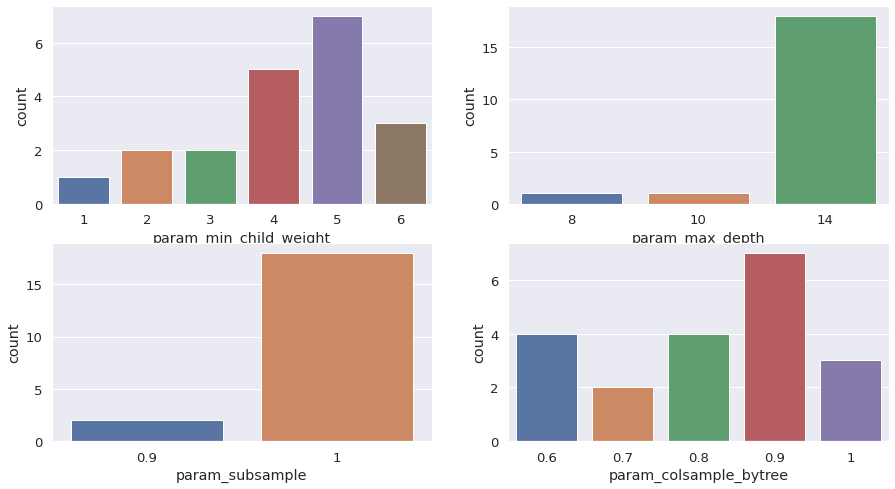

In [115]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.2)

plt.subplot(2,2,1)
sns.countplot(resultadoscv.param_min_child_weight)
plt.subplot(2,2,2)
sns.countplot(resultadoscv.param_max_depth)
plt.subplot(2,2,3)
sns.countplot(resultadoscv.param_subsample)
plt.subplot(2,2,4)
sns.countplot(resultadoscv.param_colsample_bytree);

In [31]:
rs_xgb.best_params_

{'subsample': 0.9,
 'min_split_loss': 0.1,
 'min_child_weight': 5,
 'max_depth': 14,
 'colsample_bytree': 0.8}

In [116]:
cv_xgb.best_params_

{'colsample_bytree': 0.9,
 'max_depth': 8,
 'min_child_weight': 1,
 'min_split_loss': 0.01,
 'subsample': 1}

### Metodos Avanzados, Optimizacion Bayesiana.

Existen metodos mas avanzados de busqueda de hiperparametros, uno de ellos utiliza metodos bayesianos para dirigir la busqueda de modo que esta se realize de manera mas eficiente.

Una forma de implementar esto facilmente en python es utilizando la libreria hyperopt. A continuacion se presenta un template para utilizar las misma.

Pueden encontrar mas informacion en: 
https://hyperopt.github.io/hyperopt/?source=post_page


In [117]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Definicion de espacio de busqueda


space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
#        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'min_split_loss' : hp.uniform('min_split_loss', 0.1, 0.9),
        'subsample' : hp.uniform('subsample', 0.5, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
       'n_estimators': 200,
        'seed': 0
    }



# Debemos generar una funcion objetivo que luego pasaremos al optimizar para minimizar
# Observar que la funcion retorna el valor negativo de accuracy, ya que como
# mencionamos el optimizador 'minimizara' ese valor

def objective(space):
    clf= xgb.XGBRegressor(
                     max_depth = int(space['max_depth']), min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), min_split_loss = space['min_split_loss'], 
                    subsample = space['subsample'], n_estimators = space['n_estimators'], gamma = space['gamma'])
    
    evaluation = [( X_train, y_train), ( X_valid, y_valid)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10, verbose=False)
    

    pred = clf.predict(X_valid)
    error = mean_squared_error(y_valid,pred, squared=False)
    print ("rmse:", error)
    return {'loss': -error, 'status': STATUS_OK }

# Correr Optimizacion
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 2000,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

rmse:                                                   
3.7049642420986335                                      
rmse:                                                                              
3.589424293231154                                                                  
rmse:                                                                              
3.433529599609515                                                                  
rmse:                                                                              
3.2631438670818818                                                                 
rmse:                                                                              
3.6435337990419807                                                                 
rmse:                                                                              
3.6196170582603377                                                                 
rmse:                                         

In [118]:
ob_params = {'colsample_bytree': 0.6774424596356765, 'gamma': 5.391813274102538, 'max_depth': 18, 'min_child_weight': 1, 'min_split_loss': 0.4407659549127785, 'subsample': 0.610872982771141}

In [119]:
ob_xgb = xgb.XGBRegressor(**ob_params)
ob_xgb.fit(X_train,y_train);
y_train_pred_ob_xgb = ob_xgb.predict(X_train)
y_valid_pred_ob_xgb = ob_xgb.predict(X_valid)

print('Conjunto de entrenamiento: modelo XGBRegressor_CV')
print('R2: ', r2_score(y_train,y_train_pred_ob_xgb))
print('MAE: ', mean_absolute_error(y_train,y_train_pred_ob_xgb))
print('MSE: ', mean_squared_error(y_train,y_train_pred_ob_xgb, squared=False))

print('Conjunto de validación: modelo XGBRegressor_CV')
print('R2: ', r2_score(y_valid,y_valid_pred_ob_xgb))
print('MAE: ', mean_absolute_error(y_valid,y_valid_pred_ob_xgb))
print('MSE: ', mean_squared_error(y_valid,y_valid_pred_ob_xgb, squared=False))

Conjunto de entrenamiento: modelo XGBRegressor_CV
R2:  0.9974943061879411
MAE:  0.17924534514407475
MSE:  0.23004404496972022
Conjunto de validación: modelo XGBRegressor_CV
R2:  0.8242834910143926
MAE:  1.3318694007498197
MSE:  1.9585885198851276


## Comparacion

Realize una tabla comparativa de los resultados obtenidos entre:

- Modelo con hiperparametros por default sin seleccion de variables
- Modelo con hiperparametros por default con seleccion de variables
- Modelo con optimizacion de hiperparametros por cada metodo

En base a los resultados exponga sus observacion relacionada tanto con la performance del modelo como de los tiempos de ejecucion.

#### Concluciones

Al reducir el número de features y quedarnos con aquellas que son más relevantes para el modelo mejoramos el desempeño y a la vez redujimos el tiempo de cálculo. Por otro lado, los métodos de optimización de hiperparámetros arrojaron resultados dispares. Por un lado, tanto GridSearchCV como RandomizedSearchCV incrementaron el desempeño, en tanto que la búsqueda bayesiana nos dio resultados similares a los iniciales. Esto puede deberse a falencias en el espacio de parámetros utilizados o en los intervalos de búsqueda seleccionados. 

El modelo que mejores métricas arroja, no solo en el conjunto de validación, es el mejor modelo obtenido con GridSearchCV.

# Aprendizaje Automático No Supervisado

### Clusterizacion como metodo de generacion de features

Vamos a utilizar a la clusterización como método de generacion de features y posteriormente vamos a correr los modelos de predicción.

Basandose en el algoritmo de KMeans, aplique el metodo de codo (elbow) para estimar la cantidad optima de clusters. 

(Opcional) En caso de que la clusterizacion este demorando mucho en ejecutarse puede aplicarse PCA en un paso previo para disminuir las dimensiones.

In [120]:
from sklearn.cluster import KMeans
from sklearn import decomposition

Text(0.5, 1.0, 'inercia de k-Means versus número de clusters')

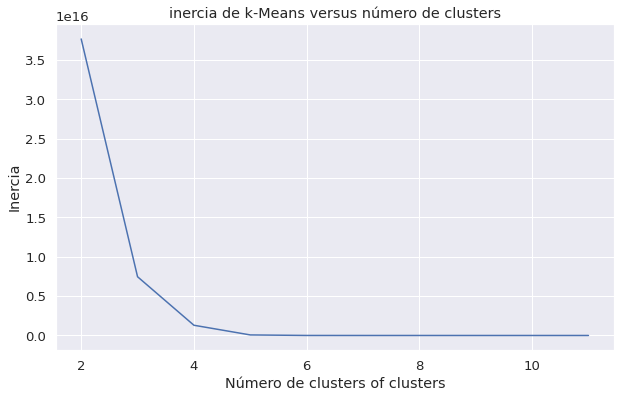

In [121]:
scores = [KMeans(n_clusters=i+2).fit(untrd_red).inertia_ for i in range(10)]

plt.figure(figsize=(10,6))
plt.plot(np.arange(2, 12), scores)
plt.xlabel('Número de clusters of clusters')
plt.ylabel("Inercia")
plt.title("inercia de k-Means versus número de clusters")

Del método del codo podemos ver que 5 clusters es el número óptimo 

Realizar la predicción del cluster del conjunto de validación.




In [122]:
n_clust = 5
km = KMeans(n_clusters=n_clust)
km.fit(untrd_red)
clusters = km.labels_

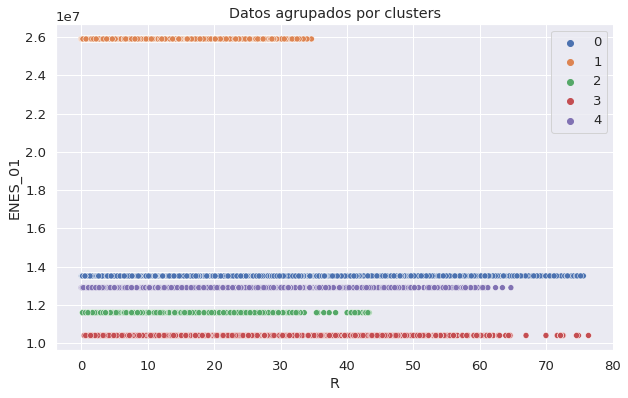

In [123]:
feature1=best_features_names[-1]
feature2=best_features_names[-2]

plt.figure(figsize=(10,6))
sns.scatterplot(data=untrd_red, x=feature1, y=feature2, hue=clusters, palette="deep")
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title("Datos agrupados por clusters");

Integre los clusters al dataset de training y vuelva a correr a entrenar el algoritmo de deteccion de mejor rendimiento.

In [124]:
untrd_red['cluster'] = clusters
print(untrd_red['cluster'].isna().sum())
untrd_red = pd.get_dummies(untrd_red, columns=['cluster'], dummy_na=False)
untrd_red.head()

0


<ipython-input-124-41ec3c7c4c81>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  untrd_red['cluster'] = clusters


,dis_trs,TIP_TRAFO_MT,CLAS_SUB_moda_PP3,sec_r_dist,TEN_LIN_SE,X,dist_to_trs,dist_buildings,Media_3ciudades,main_r_dist,...,CNOM,ARE_LOC_NU,COMP,ENES_01,R,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
0,11259.764183,1,0,1420.588809,0.23,6.914966,15507.34,53930.620056,13579.296753,31597.046506,...,2.466445,1,15507.34,13520222.0,11.510700,1,0,0,0,0
1,14306.485778,1,0,1913.237588,0.23,8.267169,18841.79,53127.744964,12494.289697,30843.182190,...,2.344369,1,18841.79,13520222.0,10.493560,1,0,0,0,0
2,13746.532291,1,0,2745.251017,0.23,8.988066,20346.48,52447.844271,12466.558120,30139.806352,...,2.293335,1,20346.48,13520222.0,12.827334,1,0,0,0,0
3,13632.021791,1,0,2992.619335,0.22,8.931264,20227.92,52237.458918,12453.790483,29924.645982,...,2.293592,1,20227.92,13520222.0,12.643447,1,0,0,0,0
4,13279.604893,1,0,3740.246825,0.23,9.395335,21196.55,51530.553766,12426.008286,29205.086143,...,2.297827,1,21196.55,13520222.0,14.145792,1,0,0,0,0


In [24]:
resultadoscv[resultadoscv['rank_test_score']==1].params[1633]

"{'colsample_bytree': 0.8, 'max_depth': 10, 'min_child_weight': 4, 'min_split_loss': 0.5, 'subsample': 0.9}"

Compare los resultados obtenidos.

In [178]:
X_train, X_valid, y_train, y_valid = train_test_split(untrd_red, y, test_size=0.2, random_state=0)
data_dmatrix = xgb.DMatrix(data=X_train,label=y)

params = cv_xgb.best_params_
#params = {'colsample_bytree': 0.8, 'max_depth': 10, 'min_child_weight': 4, 'min_split_loss': 0.5, 'subsample': 0.9}
params['n_estimators']=2000
best_model_xgb = xgb.XGBRegressor(**params)
best_model_xgb.fit(X_train, y_train)

y_train_pred_cv_xgb = best_model_xgb.predict(X_train)
y_valid_pred_cv_xgb = best_model_xgb.predict(X_valid)

print('Conjunto de entrenamiento: modelo XGBRegressor_CV')
print('R2: ', r2_score(y_train,y_train_pred_cv_xgb))
print('MAE: ', mean_absolute_error(y_train,y_train_pred_cv_xgb))
print('MSE: ', mean_squared_error(y_train,y_train_pred_cv_xgb, squared=False))

print('Conjunto de validación: modelo XGBRegressor_CV')
print('R2: ', r2_score(y_valid,y_valid_pred_cv_xgb))
print('MAE: ', mean_absolute_error(y_valid,y_valid_pred_cv_xgb))
print('MSE: ', mean_squared_error(y_valid,y_valid_pred_cv_xgb, squared=False))

Conjunto de entrenamiento: modelo XGBRegressor_CV
R2:  0.9998275436550967
MAE:  0.04372385499197773
MSE:  0.06035129365219933
Conjunto de validación: modelo XGBRegressor_CV
R2:  0.8358180549187189
MAE:  1.2707596747550622
MSE:  1.8932136176494876


### Conclusiones generales

Mediante la selección de las features más importantes pudimos disminuir el tiempo de cálculo y mejorar el desempeño del modelo. A su vez, los métodos de optimización de hiper parámetros nos permitieron refinar el modelo al encontrar un conjunto de parámetros que mejoraron las métricas. Finalmente al agrupar los datos en clusters e introducir esta información como una variable categórica (mediante hot enccoding) mejoramos aun más las métricas del modelo por default.

En particular, comensamos con 

Conjunto de validación: modelo XGBRegressor default
R2:  0.790544722650728 
MAE:  1.535932247716021 
MSE:  2.1383686314191794 

y llegamos a 

Conjunto de validación: modelo XGBRegressor_CV+Kmeans
R2:  0.8358180549187189
MAE:  1.2707596747550622
MSE:  1.8932136176494876

Mejoramos

In [129]:
from lightgbm.sklearn import LGBMRegressor

In [157]:
untrd_red.head()

,dis_trs,TIP_TRAFO_MT,CLAS_SUB_moda_PP3,sec_r_dist,TEN_LIN_SE,X,dist_to_trs,dist_buildings,Media_3ciudades,main_r_dist,...,CNOM,ARE_LOC_NU,COMP,ENES_01,R,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
0,11259.764183,1,0,1420.588809,0.23,6.914966,15507.34,53930.620056,13579.296753,31597.046506,...,2.466445,1,15507.34,13520222.0,11.510700,1,0,0,0,0
1,14306.485778,1,0,1913.237588,0.23,8.267169,18841.79,53127.744964,12494.289697,30843.182190,...,2.344369,1,18841.79,13520222.0,10.493560,1,0,0,0,0
2,13746.532291,1,0,2745.251017,0.23,8.988066,20346.48,52447.844271,12466.558120,30139.806352,...,2.293335,1,20346.48,13520222.0,12.827334,1,0,0,0,0
3,13632.021791,1,0,2992.619335,0.22,8.931264,20227.92,52237.458918,12453.790483,29924.645982,...,2.293592,1,20227.92,13520222.0,12.643447,1,0,0,0,0
4,13279.604893,1,0,3740.246825,0.23,9.395335,21196.55,51530.553766,12426.008286,29205.086143,...,2.297827,1,21196.55,13520222.0,14.145792,1,0,0,0,0


In [179]:
X_train, X_valid, y_train, y_valid = train_test_split(untrd_red, y, test_size=0.2, random_state=0)

In [180]:
lgbm = LGBMRegressor(n_estimators=600)
cv_lgbm = GridSearchCV(lgbm, param_xgb, scoring='r2', n_jobs=-1, cv=5);
cv_lgbm.fit(X_train,y_train);

[LightGBM] [Warning] Unknown parameter: min_split_loss
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


In [182]:
blgbm = cv_lgbm.best_estimator_
y_train_pred_LGBM = blgbm.predict(X_train)
y_valid_pred_LGBM = blgbm.predict(X_valid)

print('Conjunto de entrenamiento: modelo LGBMRegressor')
print('R2: ', r2_score(y_train,y_train_pred_LGBM))
print('MAE: ', mean_absolute_error(y_train,y_train_pred_LGBM))
print('MSE: ', mean_squared_error(y_train,y_train_pred_LGBM, squared=False))

print('Conjunto de validación: modelo LGBMRegressor')
print('R2: ', r2_score(y_valid,y_valid_pred_LGBM))
print('MAE: ', mean_absolute_error(y_valid,y_valid_pred_LGBM))
print('MSE: ', mean_squared_error(y_valid,y_valid_pred_LGBM, squared=False))

Conjunto de entrenamiento: modelo LGBMRegressor
R2:  0.9619757788229089
MAE:  0.6138014045880891
MSE:  0.8961426742554645
Conjunto de validación: modelo LGBMRegressor
R2:  0.8465895211498311
MAE:  1.256733089702568
MSE:  1.8300562306553816
